In [1]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
# import tensorflow_probability as tfp
import gpflow
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import *

sys.path.append('../../mogp_decomposition/')
from mwgp import GPD
from data import load_movielens_data_10m

import seaborn as sns

np.random.seed(11111986)
tf.set_random_seed(11111986)

/home/ubuntu/anaconda3/envs/mogp-dev/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/mogp-dev/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/mogp-dev/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/mogp-dev/lib

In [2]:
ml_triple_store, ml_triple_ratings = load_movielens_data_10m('../../data/ML-10M/')

read_in = open('../../data/ML-10M/splits.pkl', 'rb')
split_ids = pickle.load(read_in)
read_in.close()

../../mogp_decomposition/data.py:36: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['userId', 'movieId', 'rating', 'timestamp'])


In [3]:
N = ml_triple_store.shape[0]
I = ml_triple_store[:, 0].max()+1
J = ml_triple_store[:, 1].max()+1
K = None

In [4]:
I, J

(69878, 10677)

In [5]:
Y_te_list = []
pred_list = []
pred_var_list = []
pred_sd_list = []

In [6]:
for cv_id in range(5): 
# cv_id = 0

    with open('./ml-10m_scaler_cv'+str(cv_id)+'.pkl', 'rb') as f: 
        this_scaler = pickle.load(f)

    te_ids = split_ids[cv_id]
    tr_ids = []
    for i in range(len(split_ids)): 
        if i != cv_id: 
            tr_ids.append(split_ids[i])
    tr_ids = np.concatenate(tr_ids)

    X_tr = ml_triple_store[tr_ids][:, 0:2]
    # Y_tr = ml_triple_ratings[tr_ids][:, 0] 
    Y_tr = this_scaler.fit_transform(ml_triple_ratings[tr_ids][:, 0][:, None]).reshape(-1)

    X_te = ml_triple_store[te_ids][:, 0:2]
    # Y_te = ml_triple_ratings[te_ids][:, 0]
    Y_te = this_scaler.transform(ml_triple_ratings[te_ids][:, 0][:, None]).reshape(-1)    
    # Y_te_list.append(Y_te)

    hyper_params = {'I':I, 'J':J, 'K':K,
                    'emb_sizes': [8, 8], 
                    'M': 256, 
                    'emb_reg': 1e-1,
                    'batch_size': 2**16, 
                    'obs_mean': Y_tr.mean(), 
                    'lr': 1e-2}

    gp_md = GPD(**hyper_params)
    gp_md.save_path = './ml-10m_M=128_cv'+str(cv_id)+'/'
    gp_md.build()
    gp_md.load_params()

    n_te = X_te.shape[0]
    eval_splits = np.array_split(np.arange(n_te), 10)

    pred = np.zeros(n_te)
    pred_var = np.zeros(n_te)

    obs_mean = this_scaler.mean_[0]
    obs_std = this_scaler.scale_[0]

    for j in range(len(eval_splits)): 

        mu1, var1 = gp_md.predict(X_te[eval_splits[j]])

        this_pred = (mu1*obs_std) + obs_mean
        this_pred_vars = var1 * np.tile(obs_std, (var1.shape[0],1)) ** 2

        pred[eval_splits[j]] = this_pred.reshape(-1)
        pred_var[eval_splits[j]] = this_pred_vars.reshape(-1)

    Y_te_rescaled = this_scaler.inverse_transform(Y_te)
    
    Y_te_list.append(Y_te_rescaled)
    pred_list.append(pred)
    pred_var_list.append(pred_var)
    pred_sd = pred_var**.5
    pred_sd_list.append(pred_sd)
    

/home/ubuntu/anaconda3/envs/mogp-dev/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Build SVGP



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



/home/ubuntu/anaconda3/envs/mogp-dev/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Build SVGP


/home/ubuntu/anaconda3/envs/mogp-dev/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Build SVGP


/home/ubuntu/anaconda3/envs/mogp-dev/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Build SVGP


/home/ubuntu/anaconda3/envs/mogp-dev/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.21.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Build SVGP


In [7]:
sns.set()

In [8]:
qs = np.arange(.1, 1.1, 0.1)

In [9]:
maes_list = []
rmses_list = []

for j in range(5): 
    maes = np.zeros(10)
    rmses = np.zeros(10)
    for i in range(10):
        this_q = qs[i]
        thresh = np.quantile(pred_sd_list[j], this_q)
        inds = np.where(pred_sd_list[j] <= thresh)[0]
        maes[i] = mean_absolute_error(y_true=Y_te_list[j][inds], y_pred=pred_list[j][inds])
        rmses[i] = mean_squared_error(y_true=Y_te_list[j][inds], y_pred=pred_list[j][inds])**.5
    maes_list.append(maes)
    rmses_list.append(rmses)

In [10]:
rmses_list

[array([0.64572681, 0.66411545, 0.67829364, 0.6923906 , 0.70600822,
        0.71985445, 0.73519465, 0.75254843, 0.77320173, 0.80838096]),
 array([0.64612071, 0.66370171, 0.67858368, 0.69227336, 0.70577327,
        0.71979945, 0.73487884, 0.75249561, 0.7733598 , 0.80609313]),
 array([0.64356894, 0.66274098, 0.67908197, 0.69376754, 0.70751568,
        0.72159793, 0.73664033, 0.75347234, 0.77406041, 0.80831967]),
 array([0.64118302, 0.66264333, 0.67780733, 0.69184926, 0.70614225,
        0.72108094, 0.73687329, 0.75433608, 0.77498128, 0.80921368]),
 array([0.6416988 , 0.66009742, 0.67664854, 0.69195284, 0.70649418,
        0.72149711, 0.73685214, 0.75432348, 0.77493364, 0.8097477 ])]

In [11]:
maes_list

[array([0.49309649, 0.50842267, 0.52019565, 0.5313147 , 0.54181739,
        0.55272126, 0.56448779, 0.57768255, 0.5932437 , 0.61735309]),
 array([0.49348215, 0.50775085, 0.51988192, 0.53105405, 0.54206314,
        0.55300368, 0.56495119, 0.57842748, 0.59409938, 0.61691704]),
 array([0.49089302, 0.50699201, 0.52064629, 0.53238633, 0.54314734,
        0.55424905, 0.56589222, 0.57881797, 0.59422981, 0.61787984]),
 array([0.48908665, 0.50627483, 0.51908109, 0.53030717, 0.54147659,
        0.55315045, 0.56536481, 0.57880032, 0.59449686, 0.61816969]),
 array([0.48998408, 0.50569056, 0.51939236, 0.53166081, 0.54312059,
        0.55477816, 0.56680342, 0.58023596, 0.59575076, 0.61974954])]

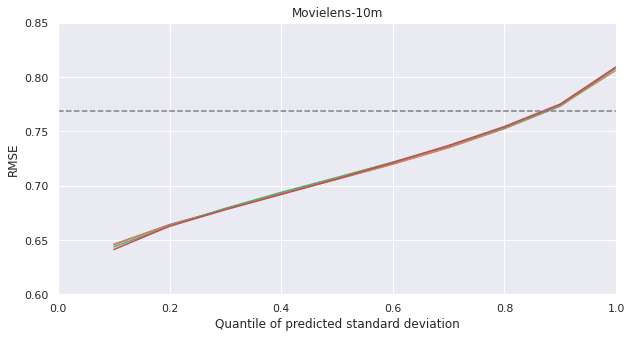

In [12]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 1)
plt.ylim(0.6, 0.85)
for j in range(4): 
    # plt.plot(qs, maes_list[j])
    plt.plot(qs, rmses_list[j])
plt.xlabel('Quantile of predicted standard deviation')
plt.ylabel('RMSE')
plt.axhline(0.769, color='gray', linestyle='--')
# plt.legend(['MAE', 'RMSE'])
plt.title('Movielens-10m')
plt.show()

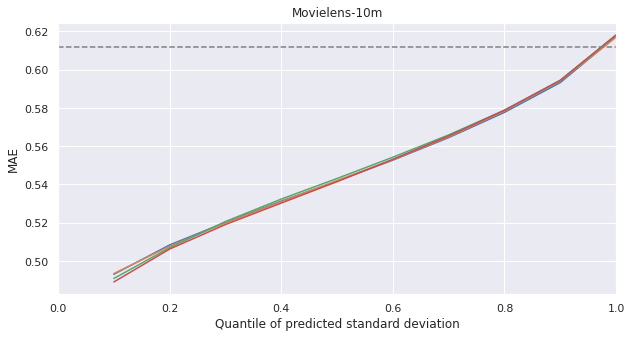

In [13]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 1)
# plt.ylim(0.6, 0.85)
for j in range(4): 
    plt.plot(qs, maes_list[j])
    # plt.plot(qs, rmses_list[j])
plt.xlabel('Quantile of predicted standard deviation')
plt.ylabel('MAE')
plt.axhline(0.612, color='gray', linestyle='--')
# plt.legend(['MAE', 'RMSE'])
plt.title('Movielens-10m')
plt.show()

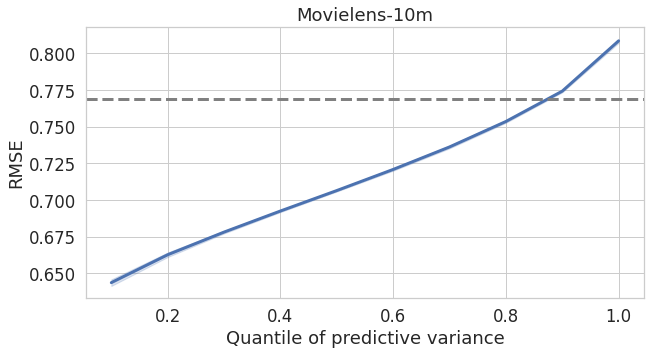

In [14]:
df_plot = pd.DataFrame({'quantile': np.tile(qs, 5), 'rmse': np.concatenate(rmses_list)})

plt.figure(figsize=(10, 5))
# sns.set(font_scale=2)
sns.set(font_scale=1.5, rc={"lines.linewidth": 3})
sns.set_style("whitegrid")
ax = sns.lineplot(x='quantile', y='rmse', data=df_plot, ci='sd')
plt.axhline(0.769, color='gray', linestyle='--')
ax.set(xlabel='Quantile of predictive variance', ylabel='RMSE', title='Movielens-10m')
plt.show()

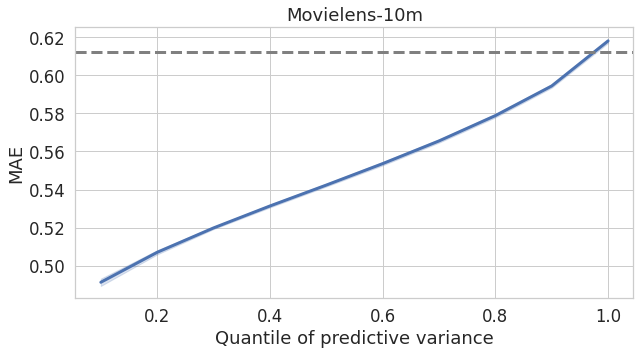

In [15]:
df_plot = pd.DataFrame({'quantile': np.tile(qs, 5), 'mae': np.concatenate(maes_list)})

plt.figure(figsize=(10, 5))
# sns.set(font_scale=2)
sns.set(font_scale=1.5, rc={"lines.linewidth": 3})
sns.set_style("whitegrid")
ax = sns.lineplot(x='quantile', y='mae', data=df_plot, ci='sd')
plt.axhline(0.612, color='gray', linestyle='--')
ax.set(xlabel='Quantile of predictive variance', ylabel='MAE', title='Movielens-10m')
plt.show()